In [ ]:
cd ../

In [ ]:
import keras
import itertools as it
import matplotlib.pyplot as pl
from tempfile import TemporaryDirectory

TMPDIR = TemporaryDirectory()
keras.backend.set_image_data_format('channels_first')

# Preprocessing

In [15]:
import os 
from skimage import io
from skimage.color import rgb2gray
from skimage import transform
from math import ceil


IMGSIZE = (100, 100)

def load_images(folder, scalefactor=(2, 2), labeldict=None):
    images = []
    labels = []
    files = os.listdir(folder)
    
    for file in (fname for fname in files if fname.endswith('.png')):
        
        img = io.imread(folder + file).astype(float)
        img = rgb2gray(img)
        # Crop since some of the real world pictures are other shape
        img = img[:IMGSIZE[0], :IMGSIZE[1]]
        # Possibly downscale to speed up processing
        img = transform.downscale_local_mean(img, scalefactor)
        # normalize image range
        img -= np.min(img)
        img /= np.max(img)
        images.append(img)
            
        if labeldict is not None:
            # lookup label for real world data in dict generated from labels.txt
            key, _ = os.path.splitext(file)
            labels.append(labeldict[key])
        else:
            # infere label from filename
            if file.find("einstein") > -1 or file.find("curie") > -1:
                labels.append(1)
            else:
                labels.append(0)
                
    return np.asarray(images)[:, None], np.asarray(labels)

x_train, y_train = load_images('data/aps/train/')
# Artifically pad Einstein's and Curie't to have balanced training set
# ok, since we use data augmentation later anyway
sel = y_train == 1
repeats = len(sel) // sum(sel) - 1
x_train = np.concatenate((x_train[~sel], np.repeat(x_train[sel], repeats, axis=0)),
                         axis=0)
y_train = np.concatenate((y_train[~sel], np.repeat(y_train[sel], repeats, axis=0)),
                         axis=0)

x_test, y_test = load_images('data/aps/test/')

rw_labels = {str(key): 0 if label == 0 else 1
             for key, label in np.loadtxt('data/aps/real_world/labels.txt', dtype=int)}
x_rw, y_rw = load_images('data/aps/real_world/', labeldict=rw_labels)

In [ ]:
from mpl_toolkits.axes_grid import ImageGrid

def imsshow(images, grid=(-1, 5)):
    assert any(g > 0 for g in grid)
    
    grid_x = grid[0] if grid[0] > 0 else len(images) // grid[1] + 1
    grid_y = grid[1] if grid[1] > 0 else len(images) // grid[0] + 1
    
    axes = ImageGrid(pl.gcf(), "111", (grid_y, grid_x), share_all=True)
    for ax, img in zip(axes, images):
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img[0], cmap='gray')
     
pl.figure(0, figsize=(16, 10))
imsshow(x_train, grid=(5, 1))
pl.show()

pl.figure(0, figsize=(16, 10))
imsshow(x_train[::-4], grid=(5, 1))
pl.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

imggen = ImageDataGenerator(rotation_range=20, 
                            width_shift_range=0.15,
                            height_shift_range=0.15,
                            shear_range=0.4,
                            fill_mode='constant',
                            cval=1.,
                            zoom_range=0.3,
                            channel_shift_range=0.1)
imggen.fit(x_train)

for batch in it.islice(imggen.flow(x_train, batch_size=5), 2):
    pl.figure(0, figsize=(16, 5))
    imsshow(batch, grid=(5, 1))
    pl.show()

# Training LeNet

First, we will train a simple CNN with a single hidden fully connected layer as a classifier.

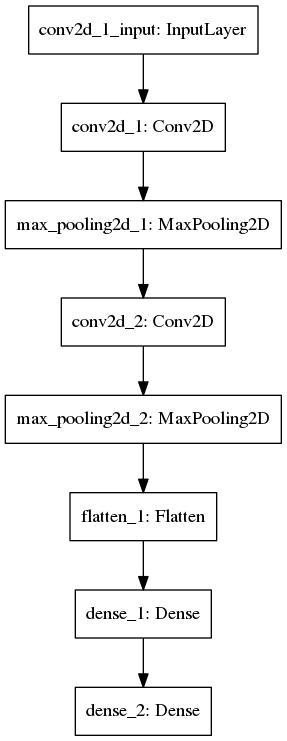

In [6]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from models import lenet
from keras.optimizers import Adam

model = lenet.generate(figsize=x_train.shape[-2:], nr_classes=1,
                       cunits=[24, 48], fcunits=[100])
optimizer = Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
plot_model(model, to_file=TMPDIR.name + '/model.png')
Image(filename=TMPDIR.name + '/model.png') 

Model succesfully loaded...


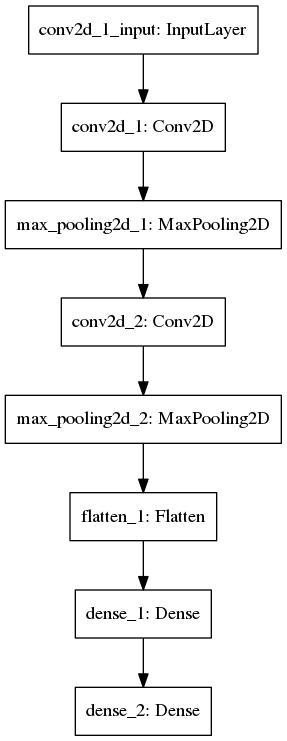

In [8]:
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.models import load_model
from IPython.display import Image
from models import lenet

try:
    model = load_model('Notebooks/aps_lenet.h5')
    print("Model succesfully loaded...")
except OSError:
    print("Saved model not found, traing...")
    model = lenet.generate(figsize=x_train.shape[-2:], nr_classes=1,
                           cunits=[24, 48], fcunits=[100])
    optimizer = Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    plot_model(model, to_file=TMPDIR.name + '/model.png')

    model.fit_generator(imggen.flow(x_train, y_train, batch_size=32), 
                        validation_data=imggen.flow(x_test, y_test),
                        steps_per_epoch=256,  epochs=10,
                        verbose=1, validation_steps=256)
    model.save('Notebooks/aps_lenet.h5')

Image(filename=TMPDIR.name + '/model.png') 

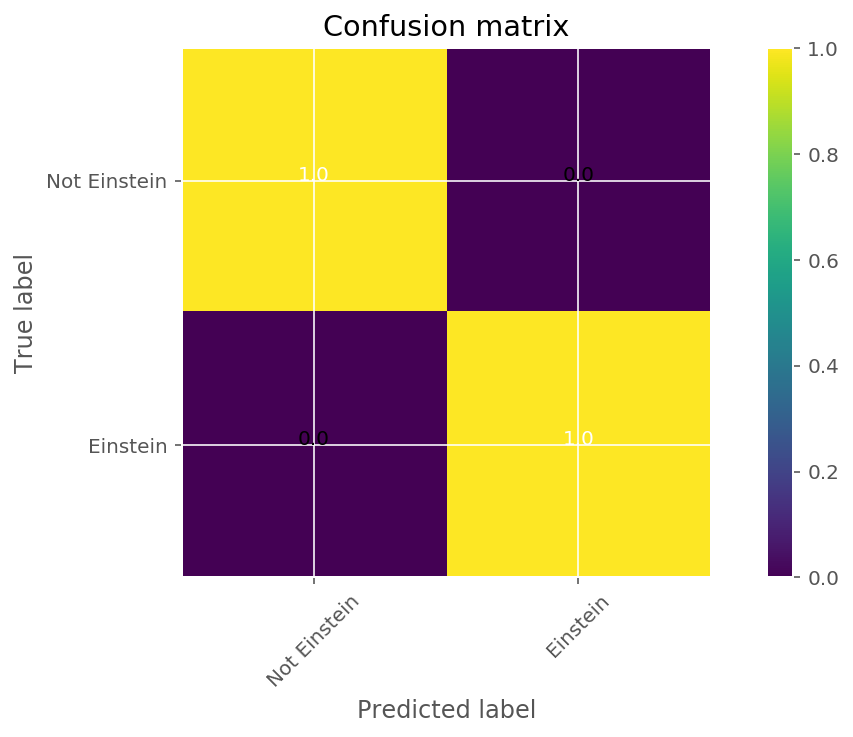

In [36]:
from sklearn.metrics import confusion_matrix

def plot_cm(cm, classes, normalize=False, 
            title='Confusion matrix', cmap=pl.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

y_pred_rw = model.predict_classes(x_rw, verbose=0).ravel()
plot_cm(confusion_matrix(y_rw, y_pred_rw), normalize=True,
        classes=["Not Einstein", "Einstein"])